In [427]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from keras.applications import vgg16
from numpy.testing import assert_allclose
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [428]:
def rr_data(imgp,img_classes,dims,limit): #read and resize
    data = []
    labels = []
    f=0
    plt.figure(1)
    for classes in img_classes:
        print('Loading data:' + classes)
        image_path=imgp+classes+'/'
        p=os.listdir(image_path)
        num_img=len(p)
        if limit>0:
            num_img=limit
        for i in range(num_img):
            current_path=image_path+p[i]
            image = cv2.imread(image_path+p[i])
            image = cv2.resize(image,dims)
            data.append(image)
            labels.append(classes)
        
        plt.subplot(2, 2, f+1)
        plt.title(classes)
        plt.imshow(image)
        plt.axis('off')
        f=f+1

   
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    
    return data, labels

In [ ]:
def normalize_data(data):
    N=len(data)
    S=np.zeros(data[0].shape)
    for i in range(N):
        S=S+1/N*data[i]
    return data-S, S

In [452]:
def report_matrix(model, testX, testY, batch_size, target_names, cmap):
    #model, testX, testY, batch_size
    #target_names list of classes
    pred = model.predict(testX, batch_size=batch_size)
    print("Classification Report")
    print(classification_report(testY.argmax(axis=1),pred.argmax(axis=1), target_names=target_names))
    cm=confusion_matrix(testY.argmax(axis=1), pred.argmax(axis=1))
    df_cm = pd.DataFrame(cm, columns=img_classes, index = img_classes)
    sns.heatmap(df_cm,annot=True,cmap=cmap, fmt='g')
    plt.title('Confusion Matrix')
    return None

In [390]:
siz=2 #resolution
dims=(32*siz,24*siz)
img_path="C:/Data/blood/dataset2-master/images/TRAIN/"
img_classes=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']
max_per_class=0  
batch_size=32

#dims=(16*siz,16*siz)
#img_path="C:/Data/animals/"
#img_classes=['cat','dog','panda']

Loading data:EOSINOPHIL
Loading data:LYMPHOCYTE
Loading data:MONOCYTE
Loading data:NEUTROPHIL
Total number of examples: 9957


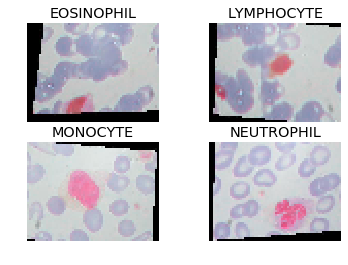

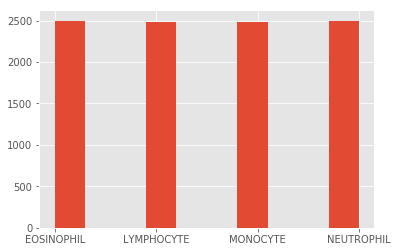

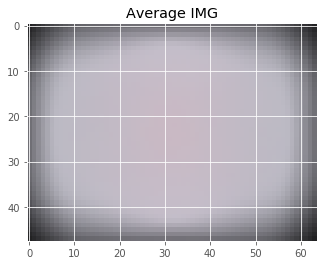

In [431]:
data, labels_raw=rr_data(imgp=img_path,img_classes=img_classes,dims=dims,limit=max_per_class)
print('Total number of examples:', len(data))

plt.figure(5)
plt.hist(labels_raw)

lb = LabelBinarizer()
labels = lb.fit_transform(labels_raw)


plt.figure(6)
data, S = normalize_data(data) #S is background
plt.imshow(S)

plt.title('Average IMG')

bck=S


(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.10, random_state=7)



The set is balanced with ~2500 samples of each class.

In [319]:
unique, counts = np.unique(labels_raw, return_counts=True)
counts

array([2497, 2483, 2478, 2499], dtype=int64)

In [456]:
LEARNING_RATE=0.03
EPOCHS = 20
bn_momentum=0.9
 
drop_out=True
dp_value=0.4    
    
model = Sequential()
chanDim=-1

model.add(Conv2D(32, (7, 7), padding="valid", input_shape=data[0].shape)) 
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))

if drop_out:
    model.add(Dropout(dp_value))
        
model.add(Conv2D(64, (4, 4), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim, momentum=bn_momentum))
model.add(Conv2D(64, (4, 4), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim, momentum=bn_momentum))
model.add(MaxPooling2D(pool_size=(2, 2)))

if drop_out:
    model.add(Dropout(dp_value))
        
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim, momentum=bn_momentum))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim, momentum=bn_momentum))
model.add(MaxPooling2D(pool_size=(2, 2)))

if drop_out:
    model.add(Dropout(dp_value))

model.add(Flatten())

model.add(Dense(64))
model.add(Dense(32))
model.add(Activation("relu"))
model.add(BatchNormalization(momentum=bn_momentum))

if drop_out:
    model.add(Dropout(0.2))
    
#softmax classifier
model.add(Dense(len(img_classes)))
model.add(Activation("softmax"))


opt=Adam(lr=LEARNING_RATE, beta_1=0.90, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)

model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
model.build()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_193 (Conv2D)          (None, 42, 58, 32)        4736      
_________________________________________________________________
activation_252 (Activation)  (None, 42, 58, 32)        0         
_________________________________________________________________
batch_normalization_217 (Bat (None, 42, 58, 32)        128       
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 21, 29, 32)        0         
_________________________________________________________________
dropout_150 (Dropout)        (None, 21, 29, 32)        0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 21, 29, 64)        32832     
_________________________________________________________________
activation_253 (Activation)  (None, 21, 29, 64)        0         
__________

In [457]:
filepath='bloodcnn40.h5'
model.save(filepath)

In [458]:
#TRAIN


checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

H = model.fit(trainX, trainY, validation_data=(testX, testY),epochs=EPOCHS, batch_size=batch_size, callbacks=callbacks_list)

Train on 8961 samples, validate on 996 samples
Epoch 1/20
8961/8961 [==============================] - 264s 29ms/step - loss: 1.1497 - acc: 0.4726 - val_loss: 1.2255 - val_acc: 0.4438

Epoch 00001: loss improved from inf to 1.14973, saving model to bloodcnn40.h5
Epoch 2/20
8961/8961 [==============================] - 247s 28ms/step - loss: 0.7353 - acc: 0.6743 - val_loss: 0.8150 - val_acc: 0.6988

Epoch 00002: loss improved from 1.14973 to 0.73528, saving model to bloodcnn40.h5
Epoch 3/20
8961/8961 [==============================] - 251s 28ms/step - loss: 0.5362 - acc: 0.7734 - val_loss: 0.4671 - val_acc: 0.7962

Epoch 00003: loss improved from 0.73528 to 0.53616, saving model to bloodcnn40.h5
Epoch 4/20
8961/8961 [==============================] - 276s 31ms/step - loss: 0.4347 - acc: 0.8314 - val_loss: 0.5956 - val_acc: 0.7731

Epoch 00004: loss improved from 0.53616 to 0.43471, saving model to bloodcnn40.h5
Epoch 5/20
8961/8961 [==============================] - 292s 33ms/step - loss

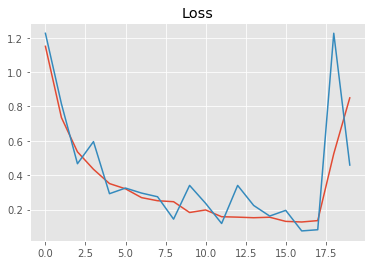

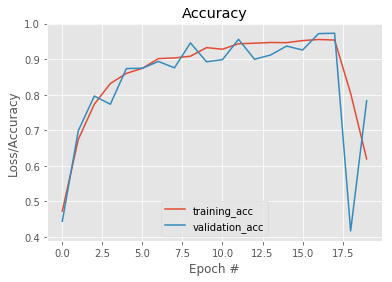

In [459]:
 # plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(3)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.figure(4)
plt.plot(N, H.history["acc"], label="training_acc")
plt.plot(N, H.history["val_acc"], label="validation_acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [468]:
#Only use to continute training.

new_model = load_model(filepath)
#assert_allclose(model.predict(trainX),new_model.predict(trainX),1e-5)

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
new_model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=batch_size, callbacks=callbacks_list)


Train on 8961 samples, validate on 996 samples
Epoch 1/20
8961/8961 [==============================] - 251s 28ms/step - loss: 0.1043 - acc: 0.9623 - val_loss: 0.0552 - val_acc: 0.9749

Epoch 00001: loss improved from inf to 0.10434, saving model to bloodcnn40.h5
Epoch 2/20
8961/8961 [==============================] - 240s 27ms/step - loss: 0.1058 - acc: 0.9617 - val_loss: 0.1861 - val_acc: 0.9167

Epoch 00002: loss did not improve from 0.10434
Epoch 3/20
8961/8961 [==============================] - 238s 27ms/step - loss: 0.1134 - acc: 0.9614 - val_loss: 0.0907 - val_acc: 0.9669

Epoch 00003: loss did not improve from 0.10434
Epoch 4/20
8961/8961 [==============================] - 236s 26ms/step - loss: 0.1185 - acc: 0.9611 - val_loss: 0.2116 - val_acc: 0.9207

Epoch 00004: loss did not improve from 0.10434
Epoch 5/20
8961/8961 [==============================] - 241s 27ms/step - loss: 0.0940 - acc: 0.9692 - val_loss: 0.0608 - val_acc: 0.9789

Epoch 00005: loss improved from 0.10434 to 0

In [469]:
new_model = load_model(filepath)

Training set classification report
Classification Report
              precision    recall  f1-score   support

  EOSINOPHIL       0.95      0.99      0.97      2254
  LYMPHOCYTE       0.99      1.00      1.00      2223
    MONOCYTE       1.00      1.00      1.00      2235
  NEUTROPHIL       0.99      0.94      0.97      2249

   micro avg       0.98      0.98      0.98      8961
   macro avg       0.98      0.98      0.98      8961
weighted avg       0.98      0.98      0.98      8961



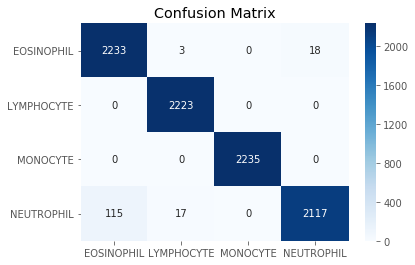

In [466]:
print('Training set classification report')
report_matrix(model=new_model, testX=trainX, testY=trainY, batch_size=batch_size, target_names=test_lb.classes_,cmap='Blues')

98% Training set accuracy. Mostly NEUTROPHIL cells are wrongly classified as EOSINOPHIL.

Development set classification report
Classification Report
              precision    recall  f1-score   support

  EOSINOPHIL       0.95      0.99      0.97       243
  LYMPHOCYTE       1.00      1.00      1.00       260
    MONOCYTE       0.98      1.00      0.99       243
  NEUTROPHIL       0.99      0.93      0.96       250

   micro avg       0.98      0.98      0.98       996
   macro avg       0.98      0.98      0.98       996
weighted avg       0.98      0.98      0.98       996



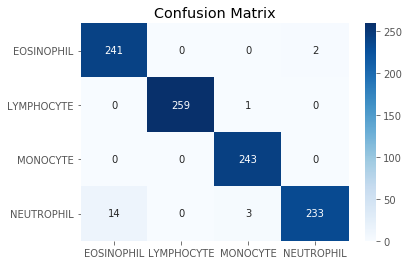

In [470]:
print('Development set classification report')
report_matrix(model=new_model, testX=testX, testY=testY, batch_size=batch_size, target_names=test_lb.classes_,cmap='Blues')

98% Development set accuracy.

Load up images the model have never seen before.

In [471]:
siz=2 #resolution
dims=(32*siz,24*siz)
img_path1="C:/Data/blood/dataset2-master/images/TEST/"
img_classes=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']


Loading data:EOSINOPHIL
Loading data:LYMPHOCYTE
Loading data:MONOCYTE
Loading data:NEUTROPHIL
Total number of test examples: 2487


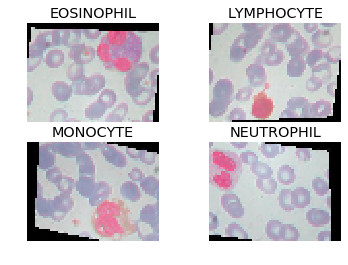

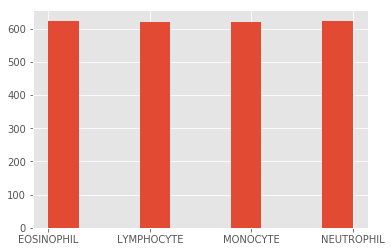

In [472]:
test_data, test_labels_raw=rr_data(imgp=img_path1,img_classes=img_classes,dims=dims,limit=0)
print('Total number of test examples:', len(test_data))

plt.figure(7)
plt.hist(test_labels_raw)

test_lb = LabelBinarizer()
test_labels = test_lb.fit_transform(test_labels_raw)

test_data=test_data-S #remove background
#test_data, S = normalize_data(test_data)

Classification Report
              precision    recall  f1-score   support

  EOSINOPHIL       0.84      0.77      0.80       623
  LYMPHOCYTE       0.98      0.99      0.98       620
    MONOCYTE       0.98      0.87      0.92       620
  NEUTROPHIL       0.73      0.86      0.79       624

   micro avg       0.87      0.87      0.87      2487
   macro avg       0.88      0.87      0.87      2487
weighted avg       0.88      0.87      0.87      2487



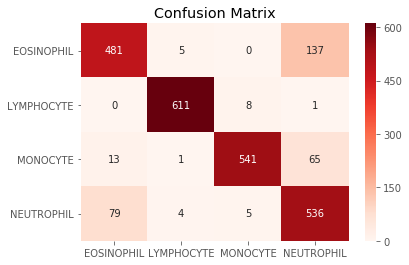

In [473]:
report_matrix(model=new_model, testX=test_data, testY=test_labels, batch_size=batch_size, target_names=test_lb.classes_,cmap='Reds')

Total accuracy: 88%
The model has trouble distinguishing the NEUTROPHIL cells with only 73% accuracy. Some NEUTROPHIL are wrongly classified as EOSINOPHIL.

Next step - data augmentation. Perhaps increase dropout.